In [5]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# URL der Spielerseite
url_home = "https://swgoh.gg/"

def fun_toon_stats(url):
    # Initialisiere das Dictionary für die Ergebnisse
    ergebnisse_dict = {}
    
    # HTML-Seite abrufen
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
    else:
        print("Fehler beim Abrufen der Website.")
        exit()
    
    # Relevanten HTML-Code finden (gemeinsames Skript)
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Finde das Skript-Tag, das die Datenpunkte für alle Diagramme enthält
    data_script = soup.find("script", string=re.compile(r"new Highcharts.Chart\({\s*chart: {\s*renderTo: 'character-stats-"))
    
    # Extrahiere den Inhalt des Skripts
    data_script_content = data_script.string
    
    # Finde alle Highcharts.Chart-Aufrufe im data_script
    chart_aufraeufe = re.findall(r"new Highcharts.Chart\({(.*?)}\)", data_script_content, re.DOTALL)
    
    # Annahme: Du hast bereits chart_aufraeufe aus dem data_script extrahiert
    for aufrauf in chart_aufraeufe:
    
         # Extrahiere den Titel aus dem Aufrauf
        title_start = aufrauf.find("title: {") + len("title: {")
        title_end = aufrauf.find("}", title_start)
        title_string = aufrauf[title_start:title_end]
    
        # Extrahiere den Text des Titels
        title_match = re.search(r"text: '(.*?)'", title_string)
        if title_match:
            diagramm_titel = title_match.group(1).split(" (Nearest ")[0]  # Entferne den Zusatz
        else:
            diagramm_titel = "Custom Diagram Title"  # Fallback-Titel, falls kein Text gefunden wird
    
            
        # Extrahiere die Datenpunkte aus dem String
        data_start = aufrauf.find("data: [") + len("data: [")
        data_end = aufrauf.find("]", data_start)
        data_string = aufrauf[data_start:data_end]
    
        # Teile den data_string in einzelne Datenpunkte auf
        datenpunkte = data_string.split("},\n")
    
        # Extrahiere x- und y-Wertepaare
        x_werte = []
        y_werte = []
        for punkt in datenpunkte:
            x_start = punkt.find("x:") + len("x:")
            x_end = punkt.find(",", x_start)
            x = punkt[x_start:x_end].strip()
    
            y_start = punkt.find("y:") + len("y:")
            y_end = punkt.find(",", y_start)
            y = punkt[y_start:y_end].strip()
    
            if x:  # Prüfe, ob der x-Wert nicht leer ist
                x_werte.append(float(x))
            if y:  # Prüfe, ob der y-Wert nicht leer ist
                y_werte.append(float(y))  # Ändere y zu float
        
        # Berechne den gewichteten Mittelwert und die gewichtete Standardabweichung
        x_array = np.array(x_werte)
        y_array = np.array(y_werte)
        gewichteter_mittelwert = np.average(x_array, weights=y_array)
        gewichtete_std = np.sqrt(np.average((x_array - gewichteter_mittelwert) ** 2, weights=y_array))
        # Berechne das Verhältnis SD/Mean
    
        # Speichere die Ergebnisse im Dictionary
        ergebnisse_dict[diagramm_titel] = [gewichteter_mittelwert, gewichtete_std]
    
    # Gib das Ergebnis aus
    return ergebnisse_dict

def fun_toon_base(url):
    # HTML-Seite abrufen
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
    else:
        print("Fehler beim Abrufen der Website.")
        exit()
    
    # Relevanten HTML-Code finden (gemeinsames Skript)
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Angenommen, du hast bereits die 'soup' mit den Daten
    # Finde das 'window.unit_data_lookup'-Objekt
    unit_data_lookup_script = soup.find("script", string=re.compile(r"window.unit_data_lookup"))
    if unit_data_lookup_script:
        # Extrahiere den Textinhalt des Skripts
        unit_data_lookup_text = unit_data_lookup_script.text
    
        # Suche nach dem GEAR_13-Teil im 'window.unit_data_lookup'
        gear_13_start = unit_data_lookup_text.find("GEAR_13:")
        if gear_13_start != -1:
            gear_13_text = unit_data_lookup_text[gear_13_start:]
    
            # Extrahiere die relevanten Werte
            relevant_values = ["Health", "Speed", "Protection", "Tenacity", "Potency", "Armor", "Resistance"]
            gear_13_data = {}
            for value in relevant_values:
                value_start = gear_13_text.find(f'"label": "{value}"')
                if value_start != -1:
                    # Suche nach dem Wert für "value"
                    value_value_start = gear_13_text.find('"value": ', value_start)
                    value_value_end = gear_13_text.find(",", value_value_start)
                    value_str = gear_13_text[value_value_start + len('"value": '):value_value_end]
                    try:
                        gear_13_data[value] = float(value_str)  # Wir verwenden float, da einige Werte Dezimalstellen haben
                    except ValueError:
                        print(f"Ungültiger Wert für {value}: {value_str}")
                else:
                    print(f"{value} nicht gefunden.")
            for section in ["Physical Offense", "Special Offense"]:
                section_start = gear_13_text.find(f'"label": "{section}"')
                if section_start != -1:
                    # Suche nach dem Wert für "Damage"
                    damage_start = gear_13_text.find('"label": "Damage"', section_start)
                    if damage_start != -1:
                        damage_value_start = gear_13_text.find('"value": ', damage_start)
                        damage_value_end = gear_13_text.find(",", damage_value_start)
                        damage_str = gear_13_text[damage_value_start + len('"value": '):damage_value_end]
                        try:
                             gear_13_data["Attack Damage" if section == "Physical Offense" else "Special Damage"] = float(damage_str)
                        except ValueError:
                            print(f"Ungültiger Wert für {section} Damage: {damage_str}")
                    else:
                        print(f"Damage für {section} nicht gefunden.")
                else:
                    print(f"{section} nicht gefunden.")
    
            
        else:
            print("GEAR_13 nicht gefunden.")
    else:
        print("window.unit_data_lookup nicht gefunden.")
    
    return gear_13_data

def fun_toon_player(url):
    # HTML-Seite abrufen
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
    else:
        print("Fehler beim Abrufen der Website.")
        exit()
    
    # Relevanten HTML-Code finden
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Extrahiere die Werte
    def extract_stat(label):
        stat_element = soup.find("span", class_="unit-stat-group-stat-label", string=label)
        if stat_element:
            value_element = stat_element.find_next("span", class_="unit-stat-group-stat-value")
            if value_element:
                value_text = value_element.text.strip()
                # Extrahiere den Wert (ohne Ausrüstung)
                value = value_text.split("(")[0].replace(",", "").strip()  # Entferne Tausendertrennzeichen
                if "%" in value:
                    # Prozentwert in Fließkommazahl umwandeln
                    value = float(value.replace("%", ""))
                    if label in ["Tenacity", "Potency"]:
                        value /= 100  # Teile durch 100
                else:
                    value = float(value)
                return value
        return None
    
    # Daten in einer Dictionary-Struktur speichern
    data = {
        "Health": extract_stat("Health"),
        "Speed": extract_stat("Speed"),
        "Protection": extract_stat("Protection"),
        "Tenacity": extract_stat("Tenacity"),
        "Potency": extract_stat("Potency"),
        "Armor": extract_stat("Armor"),
        "Resistance": extract_stat("Resistance"),
        "Attack Damage": extract_stat("Physical Damage"),
        "Special Damage": extract_stat("Special Damage")
    }
    
    return data

def get_toon_score(player_id, toon):
    
    # Kombiniere die Basis-URL mit dem relativen Pfad zum Charakter
    url_toon_player = urljoin(url_home, f"p/{player_id}/characters/{toon}")
    url_toon_base = urljoin(url_home, f"characters/{toon}") 
    url_toon_stats = urljoin(url_home, f"characters/{toon}/data/stats?filter_type=guild_100_gp") 
            
    toon_stats = fun_toon_stats(url_toon_stats)    
    toon_base = fun_toon_base(url_toon_base)   
    toon_player = fun_toon_player(url_toon_player)
    
    # Führen Sie die Einträge aus toon_base und toon_player in toon_stats zusammen
    for key in toon_stats:
        toon_stats[key].append(toon_base[key])
        toon_stats[key].append(toon_player[key])
    
    gewichte = []
    wertung = []
    
    for key in toon_stats:
        values = toon_stats[key]
        
        gewichte.append( (values[0] - values[2])/(values[2] + values[0]) )
        wertung.append( (values[3] - values[0])/(values[1] + 0) )
    
    gewichte = np.array(gewichte)
    gewichte = gewichte/np.sum(gewichte)
    wertung = np.array(wertung)
    
    scores = gewichte*wertung
    
    score = np.sum(scores)

    return score

def fun_get_toon_list(player_id):

    url_player = urljoin(url_home, f"p/{player_id}/characters/")
    
    # HTML-Seite abrufen
    response = requests.get(url_player)
    if response.status_code == 200:
        html_content = response.content
    else:
        print("Fehler beim Abrufen der Website.")
        exit()
    
    # Relevanten HTML-Code finden
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Dictionary für die Charaktere erstellen
    toons = {}
    
    # Alle Charaktere durchgehen
    for char_div in soup.find_all("div", class_="collection-char"):
        char_name = char_div["data-name-lower"]
        char_url = char_div.find("a")["href"]
        if char_div.find("div", class_="character-portrait__rframe"):
            # Charakter hat Reliktstufe erreicht
            char_url_parts = char_url.split("/")
            char_url_name = char_url_parts[-1]
            toons[char_name] = char_url_name

    return toons





In [35]:
    
#player_id = "559143933" #KoCa
player_id = "859954944" #TrueSway
#player_id = "656848841" # Shadow
player_id = "568593313" #
toon_list = fun_get_toon_list(player_id)


for name, url_name in toon_list.items():
    score = get_toon_score(player_id, url_name)
    toon_list[name] = score

# Nach dem Score sortieren (absteigend)
sorted_chars = sorted(toon_list.items(), key=lambda x: x[1], reverse=True)
"""
for char, score in sorted_chars:
    print(f"{char}: {score}")

char_scores_values = [v[1] for v in sorted_chars]

# Histogramm erstellen
plt.figure(figsize=(5, 4))
plt.hist(char_scores_values, bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Score")
plt.ylabel("Anzahl der Charaktere")
plt.title("Charakter-Scores Histogramm")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Anzeige des Histogramms
plt.tight_layout()
plt.show()
"""

'\nfor char, score in sorted_chars:\n    print(f"{char}: {score}")\n\nchar_scores_values = [v[1] for v in sorted_chars]\n\n# Histogramm erstellen\nplt.figure(figsize=(5, 4))\nplt.hist(char_scores_values, bins=10, color="skyblue", edgecolor="black")\nplt.xlabel("Score")\nplt.ylabel("Anzahl der Charaktere")\nplt.title("Charakter-Scores Histogramm")\nplt.grid(axis="y", linestyle="--", alpha=0.7)\n\n# Anzeige des Histogramms\nplt.tight_layout()\nplt.show()\n'

In [38]:
import pandas as pd
pd.set_option("display.max_rows", None)
df = pd.DataFrame(sorted_chars, columns=["Character", "Score"])
print(df)

                          Character     Score
0                 emperor palpatine  0.778159
1                       dash rendar  0.747776
2                        starkiller  0.739785
3                               pao  0.640006
4                            wicket  0.631998
5             ahsoka tano (fulcrum)  0.581098
6                             omega  0.533269
7                       darth traya  0.529795
8                      kelleran beq  0.510079
9                       darth malak  0.499127
10         clone sergeant - phase i  0.412566
11                      royal guard  0.352336
12                      nute gunray  0.333091
13                ig-100 magnaguard  0.330141
14                       zam wesell  0.324287
15                    princess leia  0.301199
16                  gamorrean guard  0.296870
17                       mon mothma  0.272824
18               jedi knight anakin  0.262483
19                  ct-5555 "fives"  0.247677
20                         ben sol

In [26]:

#player_id = ["559143933","859954944", "128571155", "656848841"]
#player_name = ["KoCa","TrueSway", "Garuba Daora", "Shadowcat"]


player_id = ["128571155", "663265392", "568593313"]
player_name = [ "Garuba Daora", "Goldbeard Ceadeus", "JodaNot"]

scortable = []

for id in player_id:
    print(id)
        
    toon_list = fun_get_toon_list(id)
    
    for name, url_name in toon_list.items():
        score = get_toon_score(id, url_name)
        toon_list[name] = score
    
    # Nach dem Score sortieren (absteigend)
    sorted_chars = sorted(toon_list.items(), key=lambda x: x[1], reverse=True)
    
    char_scores_values = [v[1] for v in sorted_chars]

    scortable.append(char_scores_values)



128571155
663265392
568593313


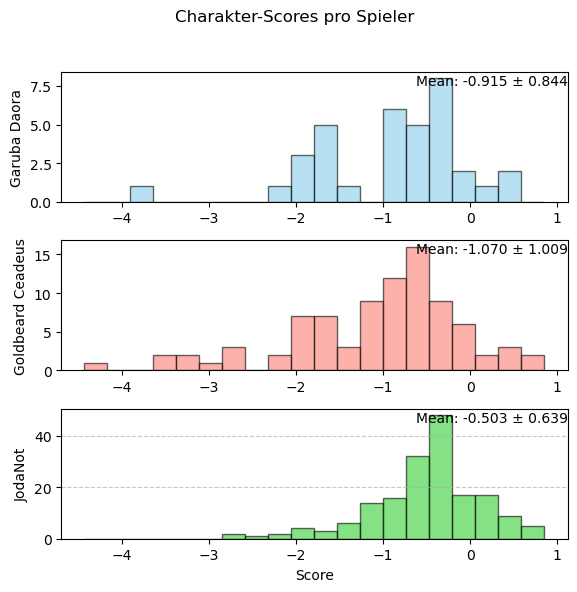

In [27]:
# Anzahl der Spieler
num_players = len(player_name)

# Gemeinsame x-Achse
all_scores = np.concatenate(scortable)
min_score = np.min(all_scores)
max_score = np.max(all_scores)

# Größe des Diagramms anpassen (x und y)
x = 6  # Breite
y = 2 * num_players  # Höhe

# Farben für die Histogramme
colors = ["skyblue", "salmon", "limegreen", "gold"]

# Subplots erstellen
fig, axs = plt.subplots(num_players, 1, figsize=(x, y))

for i in range(num_players):
    n, bins, _ = axs[i].hist(scortable[i], bins=20, alpha=0.6, color=colors[i], edgecolor="black", range=(min_score, max_score))
    axs[i].set_ylabel(player_name[i])

    # Mittelwert und Standardabweichung berechnen
    mean = np.mean(scortable[i])
    std = np.std(scortable[i])

    # Text mit Mittelwert und Standardabweichung hinzufügen
    axs[i].text(0.7, 0.9, f"Mean: {mean:.3f} ± {std:.3f}", transform=axs[i].transAxes, fontsize=10)

# Nur beim unteren Plot x-Achsen-Ticks anzeigen
axs[-1].set_xlabel("Score")

plt.suptitle("Charakter-Scores pro Spieler")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Anzeige der Diagramme
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [33]:
np.sum(np.array(scortable[2])>0)


33